In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00


In [2]:
!pip install roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 62.1 MB/s eta 0:00:00


# **COURT KEYPOINT MODEL**

In [21]:
from roboflow import Roboflow

rf = Roboflow(api_key="0kQ2Y59dCvj2w9KNJBdJ")
project = rf.workspace("roboflow-jvuqo").project("basketball-court-detection-2")
version = project.version(15)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to basketball-court-detection-2-15 in yolov8:: 100%|██████████| 2932/2932 [00:01<00:00, 2484.01it/s]


In [24]:
!yolo task=pose mode=train model=yolo11m-pose.pt data=/content/basketball-court-detection-2-15/data.yaml epochs=25 imgsz=640 plots=True

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/basketball-court-detection-2-15/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

# **PLAYER MODEL TRAINING**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DeepSport - Basketball Instants Dataset Converted to YOLO format

In [15]:
!unzip -q /content/drive/MyDrive/yolo_bounding_box.zip -d /content/basketball_players

In [16]:
!unzip -q /content/drive/MyDrive/yolo_seg.zip -d /content/basketball_players

**Checking YOLO Conversion Alignment**

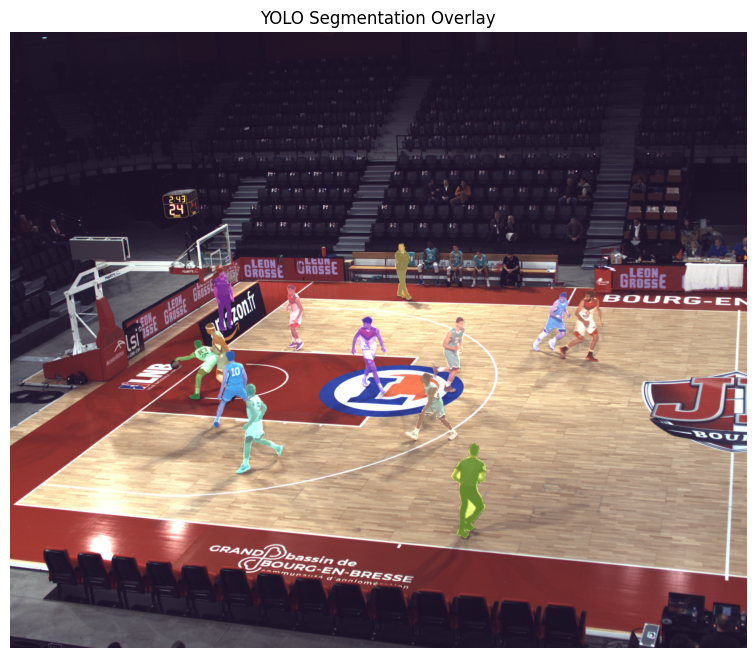

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_yolo_segmentation_mask(label_path, image_shape):
    """
    Loads YOLO-format polygon masks and converts to binary masks.

    Parameters:
    - label_path: str, path to .txt file
    - image_shape: tuple (H, W) of the image

    Returns:
    - masks: list of binary mask arrays (H, W)
    - class_ids: list of class indices
    """
    H, W = image_shape
    masks = []
    class_ids = []

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        # Convert normalized points to pixel coordinates
        points = np.array(coords).reshape(-1, 2)
        points[:, 0] *= W
        points[:, 1] *= H
        points = points.astype(np.int32)

        # Create empty binary mask
        mask = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(mask, [points], 1)

        masks.append(mask)
        class_ids.append(class_id)

    return masks, class_ids


def overlay_masks(image, masks, alpha=0.5, colors=None):
    image = image.copy()

    if colors is None:
        rng = np.random.default_rng(seed=42)
        colors = rng.integers(0, 255, size=(len(masks), 3)).tolist()

    for mask, color in zip(masks, colors):
        color_mask = np.zeros_like(image, dtype=np.uint8)
        color_mask[mask > 0] = color
        image = cv2.addWeighted(image, 1, color_mask, alpha, 0)

    return image


# === Example Usage ===
image_path = "/content/basketball_players/yolo_seg/val/images/camcourt1_1512405932787_0.png"
label_path = "/content/basketball_players/yolo_seg/val/labels/camcourt1_1512405932787_0.txt"

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks, class_ids = load_yolo_segmentation_mask(label_path, image.shape[:2])
overlayed = overlay_masks(image_rgb, masks)
plt.figure(figsize=(12, 8))
plt.imshow(overlayed)
plt.axis('off')
plt.title("YOLO Segmentation Overlay")
plt.show()


# YOLO Model Training

Segmentation Model

In [26]:
!yolo task=segment mode=train model=yolo11m-seg.pt data=/content/basketball_players/yolo_seg/data.yaml epochs=25 imgsz=640 plots=True

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/basketball_players/yolo_seg/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0

Bounding Box Model

In [28]:
!yolo task=detect mode=train model=yolo11m.pt data=/content/basketball_players/yolo_bounding_box/data.yaml epochs=25 imgsz=640 plots=True

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/basketball_players/yolo_bounding_box/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

In [ ]:
!yolo task=detect mode=val model=/content/runs/segment/train/weights/best.pt data=/content/basketball_players/yolo_seg/data.yaml

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1791.7±655.5 MB/s, size: 4709.2 KB)
val: Scanning /content/basketball_players/yolo_seg/val/labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100% 37/37 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0% 0/3 [00:00<?, ?it/s]WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for spe

# RF-DETR Model Training

In [3]:
!pip install rfdetr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.0 MB/s eta 0:00:00


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="0kQ2Y59dCvj2w9KNJBdJ")
project = rf.workspace("roboflow-universe-projects").project("basketball-players-fy4c2")
version = project.version(25)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Basketball-Players-25 in coco:: 100%|██████████| 1204/1204 [00:01<00:00, 1084.79it/s]


In [6]:
from rfdetr import RFDETRBase

model = RFDETRBase()

Loading pretrain weights


In [7]:
model.train(
    dataset_dir="/content/Basketball-Players-25",
    epochs=10,
    batch_size=4,
    grad_accum_steps=4,
    lr=1e-4,
    output_dir="/content/rfdetroutput"
)

TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir /content/rfdetroutput' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=10, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nhead

Epoch: [0]  [ 0/71]  eta: 0:12:24  lr: 0.000100  class_error: 97.73  loss: 10.9311 (10.9311)  loss_ce: 1.4661 (1.4661)  loss_bbox: 0.4159 (0.4159)  loss_giou: 0.8067 (0.8067)  loss_ce_0: 1.4790 (1.4790)  loss_bbox_0: 0.4238 (0.4238)  loss_giou_0: 0.8733 (0.8733)  loss_ce_1: 1.4507 (1.4507)  loss_bbox_1: 0.4340 (0.4340)  loss_giou_1: 0.8561 (0.8561)  loss_ce_enc: 1.4422 (1.4422)  loss_bbox_enc: 0.4074 (0.4074)  loss_giou_enc: 0.8762 (0.8762)  loss_ce_unscaled: 1.4661 (1.4661)  class_error_unscaled: 97.7273 (97.7273)  loss_bbox_unscaled: 0.0832 (0.0832)  loss_giou_unscaled: 0.4034 (0.4034)  cardinality_error_unscaled: 3888.7500 (3888.7500)  loss_ce_0_unscaled: 1.4790 (1.4790)  loss_bbox_0_unscaled: 0.0848 (0.0848)  loss_giou_0_unscaled: 0.4366 (0.4366)  cardinality_error_0_unscaled: 3888.2500 (3888.2500)  loss_ce_1_unscaled: 1.4507 (1.4507)  loss_bbox_1_unscaled: 0.0868 (0.0868)  loss_giou_1_unscaled: 0.4280 (0.4280)  cardinality_error_1_unscaled: 3888.7500 (3888.7500)  loss_ce_enc_unsca

KeyboardInterrupt: 

**Exporting to ONNX**

In [2]:
!pip install rfdetr[onnxexport] -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.5 MB/s eta 

In [8]:
from rfdetr import RFDETRBase

model = RFDETRBase(pretrain_weights="/content/checkpoint_best_regular1.pth")

model.export()

Loading pretrain weights
Exporting model to ONNX format
PyTorch inference output shapes - Boxes: torch.Size([1, 3900, 4]), Labels: torch.Size([1, 3900, 10])

Successfully exported ONNX model: output/inference_model.onnx
Successfully exported ONNX model to: output/inference_model.onnx
ONNX export completed successfully
